## I. Introduction

For this project, we will train an agent to navigate (and collect bananas!) in a large, square world.  

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.  Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.  

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  Given this information, the agent has to learn how to best select actions.  Four discrete actions are available, corresponding to:
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.


## II. Learning algorithm

In this exercise, I use Deep Q-Learning algorythm from OpenAI Gym's LunarLander environment.

First of all 37 is not significant number of dimentions, so we do not need some advanced network architectures (like CNN) to solve that task. Simple fully connected network will do a trick.

Actually I do not think that moving backward is a good action to be selected any time. Indeed, agent have no information about what is there, so it can accidentally take blue banana. Better atrategy is turn around and see if it should go there. Decreasing of number of actions are leads to simpler netowork, increase learining speed and so on.

I selected network with 37 inputs (for dimentions of state), 3 outputs (for number of allowed actions), and two hidden layers with 256 dimentions each (the size was chosen arbitrarily, and in the experiment it showed itself well).

I made some more changes to the source code.

First, there was a lot of seed in the code. However, these seeds do not affect the Unity environment (which are seems to be stohastic), which means the learning process, despite the seeds, becomes stochastic and not reproducible. So seeds are not working anymore and should be removed.

Then I mover ReplayBuffer to separate file, and removed from it all the mention of PyTorch (it is not buffer responsibility, to know how its data are used).

I tried to play with the hyper parameters, but they either did not give effect or worsened the result, so I left everything as is. The only parameter that was configured is epsilon.

With that setup environment are solved at sometheing around 450-500 episodes (+ ~50 episodes if backward action are not banned).

Submited model are trained for 464 episodes. It is learning curve for it.

Mean of last 100 episodes is 13.03


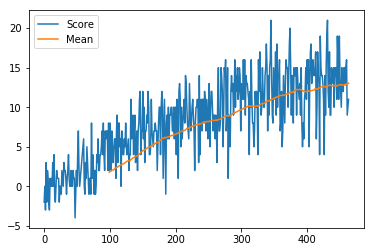

In [2]:
import pickle as pkl
with open('results.pkl','rb') as a:
    results=pkl.load(file=a)
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
df =pd.DataFrame({"Score":[x[1] for x in results]})
df['Mean'] = df['Score'].rolling(100).mean()
print("Mean of last 100 episodes is {}".format(float(df['Mean'][-1:])))
df.plot()
plt.show()    

So it seems network are still can to learn something...

In [1]:
import torch
from dqn_agent import Agent
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="C:\Banana_Windows_x86_64\Banana.exe") #replace by your path...
agent = Agent(37,3) #action "backward" is banned
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


We can see how trained network are working (you can also can see some intermediate result setting the file name 'checkpoints/checkpoint.epXX.pth', instead of 'checkpoints/checkpoint.trained.pth', where XX is number of episodes after which snapshots are made, which can be 50,100,150,200,250,300,350, 400 or 450). You can run cell bellow for several times.

In [6]:
filename = 'checkpoints/checkpoint.trained.pth'
agent.qnetwork_local.load_state_dict(torch.load(filename))
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(eps=0,state=state)        # select an action
    if action != 0:
        action_env = action + 1
    else:
        action_env = action
    env_info = env.step(int(action_env))[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:
        print("Score {}".format(score))
        break 

Score 23.0


In [7]:
env.close()

## III. Ideas for Future Work

The main problem of the current network is that it sometimes freezes up starting to turn left and right. We can fix it by setting a some small epsilon, but it is not very good solution. May be we can do some improvement by adding some negative reward if the agent returns to the state in which he was already in this episode - but maybe it will not work due to the use of ReplayBuffer. Another solution is to store the state in this episode, and if we were already in the current state, do not allow the same action to be repeated.

Also we can try to learn from visual_observations instead of vector_observations, and try some other features like Prioritized Experience Replay, Dueling